<div dir=ltr align=center>In the name of God</div>
<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
sharif university of technology, CE department
</font>
<br>
<br>
<font size=6>
Homework 1.2
</font><br>
<font size=4>
Deep learning method
</font>

**First-Name:** Mohammad Hossein

**Last-Name:** Sameti

**Student-Id:** 401204932


# Download Data

##### Execute the cell below to download the data required for your homework.

In [1]:
! pip install gdown

In [2]:
import gdown

url = 'https://drive.google.com/uc?id=1-2zT-_bKjN2o2QxwSviFwbCzcWE2PnkJ'

output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-2zT-_bKjN2o2QxwSviFwbCzcWE2PnkJ
To: /content/dataset.zip
100%|██████████| 368M/368M [00:01<00:00, 241MB/s]


'dataset.zip'

In [ ]:
! unzip dataset.zip

# Import

In [4]:
import os
import numpy as np
import seaborn as sns
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io
import torch
import random
import pandas as pd
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

# Config

In [5]:

RANDOM_SEED = 42 # Must be used wherever can be used

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load and Process Data

##### This dataset contains brain MRI images and manual FLAIR abnormality segmentation masks, where each pixel value of masks indicates the presence or absence of cancer (0 and 1, respectively). The images correspond to 110 patients whose IDs are available in the patient_ids.csv file.


In [7]:
data = pd.read_csv('patient_ids.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      110 non-null    object
dtypes: object(1)
memory usage: 1008.0+ bytes


In [8]:
data.head()

,id
0,TCGA_CS_4941
1,TCGA_CS_4942
2,TCGA_CS_4943
3,TCGA_CS_4944
4,TCGA_CS_5393



### **Exercise 1 (5 points)**:

##### Please use the patient_ids.csv file and the images inside the mri_scans folder to generate a Pandas dataframe named mri_df. This dataframe should have columns labeled "patient_id", "image_path", and "mask_path".

In [9]:
Image_paths = os.listdir('/content/mri_scans')
c = 0
for i in Image_paths:
  x = os.listdir(f'/content/mri_scans/{i}')
  c += len(x)
c

7858

In [10]:
import re
Image_paths = os.listdir('/content/mri_scans')
Image_dic = {}
Image_mask_dic = {}
for image_path in Image_paths:
  Image_dic[f'/content/mri_scans/{image_path}'] = []
  Image_mask_dic[f'/content/mri_scans/{image_path}'] = []
  paths = os.listdir(f'/content/mri_scans/{image_path}')
  for path in paths:
    if 'mask' not in path:
      Image_dic[f'/content/mri_scans/{image_path}'].append(f'/content/mri_scans/{image_path}/{path}')
      Image_mask_dic[f'/content/mri_scans/{image_path}'].append(f"/content/mri_scans/{image_path}/{re.sub('.tif', '_mask.tif', path)}")


In [11]:
# TODO
patient_ids = []
image_paths = []
mask_paths = []

for patient_id in Image_dic.keys():
    patient_ids.extend([patient_id] * len(Image_dic[patient_id]))
    image_paths.extend(Image_dic[patient_id])
    mask_paths.extend(Image_mask_dic[patient_id])

data = {'patient_id': patient_ids, 'image_path': image_paths, 'mask_path': mask_paths}
mri_df = pd.DataFrame(data)
assert len(mri_df) == 3929
mri_df.head()

,patient_id,image_path,mask_path
0,/content/mri_scans/TCGA_HT_8563_19981209,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...
1,/content/mri_scans/TCGA_HT_8563_19981209,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...
2,/content/mri_scans/TCGA_HT_8563_19981209,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...
3,/content/mri_scans/TCGA_HT_8563_19981209,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...
4,/content/mri_scans/TCGA_HT_8563_19981209,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...



### **Exercise 2 (3 points)**:

##### Append a has_cancer column to the mri_df DataFrame, with values 0 indicating the absence of cancer and 1 indicating the presence of cancer. Then, convert the column to string type.

In [12]:
def is_cancerous(mask_path):
    # TODO
    image = io.imread(mask_path)
    return 1 if image.max() > 0 else 0


mri_df['has_cancer'] = mri_df['mask_path'].apply(lambda x: is_cancerous(x))
mri_df.head()

,patient_id,image_path,mask_path,has_cancer
0,/content/mri_scans/TCGA_HT_8563_19981209,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,0
1,/content/mri_scans/TCGA_HT_8563_19981209,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,1
2,/content/mri_scans/TCGA_HT_8563_19981209,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,0
3,/content/mri_scans/TCGA_HT_8563_19981209,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,0
4,/content/mri_scans/TCGA_HT_8563_19981209,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,/content/mri_scans/TCGA_HT_8563_19981209/TCGA_...,0


# Exploratory Data Analysis


### **Exercise 3 (1 points)**:

##### Calculate the number of images exhibiting the presence and absence of cancer.

In [13]:
# TODO
mri_df['has_cancer'].value_counts()

0    2556
1    1373
Name: has_cancer, dtype: int64


### **Exercise 4 (3 points)**:

##### Determine the proportion of pixels designated as cancerous in relation to the total pixel count. Perform this calculation first for all MRI images and subsequently for images displaying signs of cancer.

In [14]:
# TODO
def count_nonzero(mask_path):
  return np.count_nonzero(io.imread(mask_path))

cancerous_pixels_count = 0
cancerous_pixels_count += mri_df['mask_path'].apply(lambda x: count_nonzero(x))
total_pixels_count = 256 * 256 * 3929

print(f'The proportaion of cancerous pixels = {100 * cancerous_pixels_count / total_pixels_count}%')
print(f'The proportaion of non-cancerous pixels = {100 * (total_pixels_count - cancerous_pixels_count) / total_pixels_count}%')

The proportaion of cancerous pixels = 0       0.000000
1       0.001539
2       0.000000
3       0.000000
4       0.000000
          ...   
3924    0.000000
3925    0.000000
3926    0.000000
3927    0.000193
3928    0.000000
Name: mask_path, Length: 3929, dtype: float64%
The proportaion of non-cancerous pixels = 0       100.000000
1        99.998461
2       100.000000
3       100.000000
4       100.000000
           ...    
3924    100.000000
3925    100.000000
3926    100.000000
3927     99.999807
3928    100.000000
Name: mask_path, Length: 3929, dtype: float64%


# Visualization

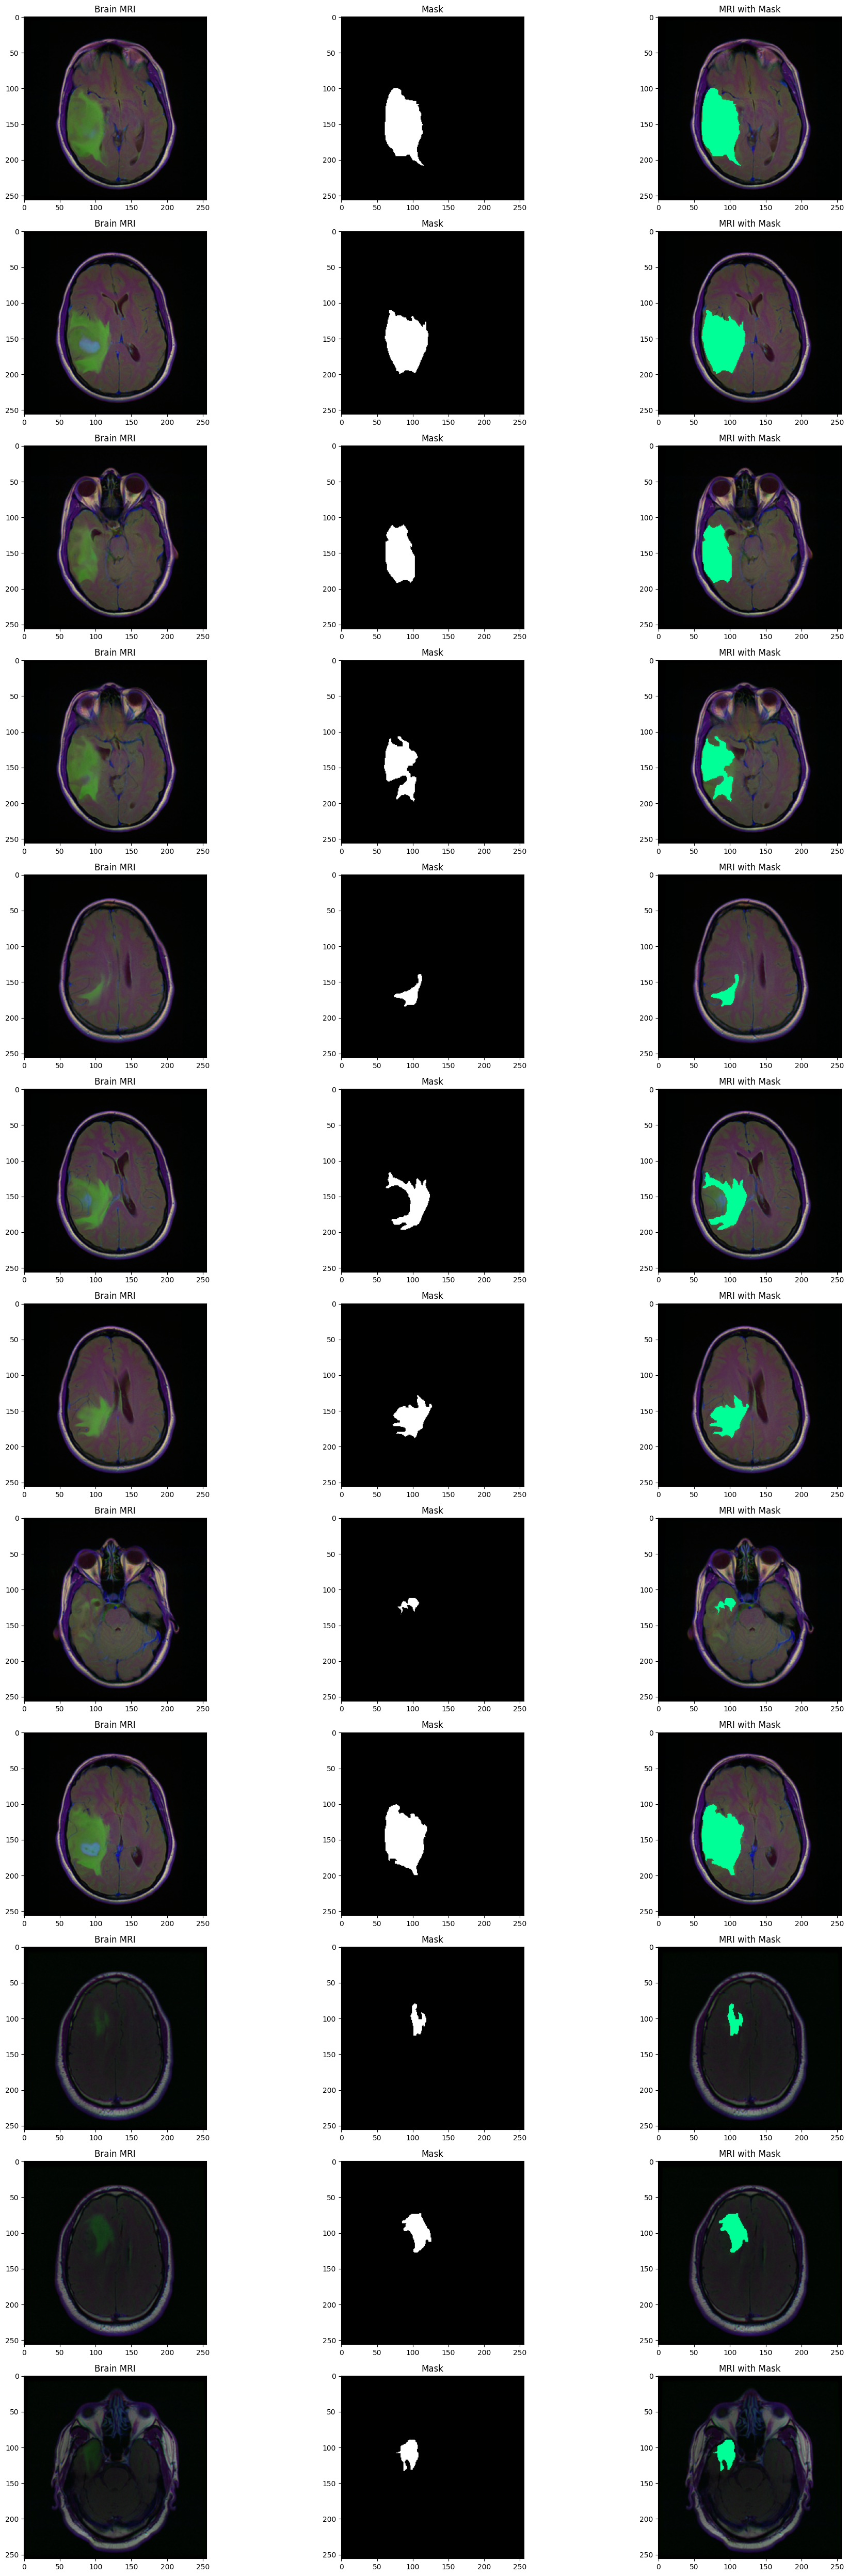

In [15]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for has_cancer in mri_df['has_cancer']:
    if (has_cancer==1):
        img = io.imread(mri_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(mri_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')

        img[mask==255] = (0,255,150)
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break

fig.tight_layout()

# Creata Dataset & DataLoader

#### Splitting To Train/Test/Val

##### Also, you are free to modify the below code.

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

#mri_df['has_cancer'] = mri_df['has_cancer'].apply(lambda x: str(x))

X_train, X_test, y_train, y_test = train_test_split(
    mri_df[['image_path']],
    mri_df[['has_cancer']],
    test_size=0.1,
    random_state=RANDOM_SEED,
    stratify = mri_df['has_cancer'],
)

train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(
    train_df[['image_path']],
    train_df[['has_cancer']],
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify = train_df['has_cancer']
)

train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)

#train_df = pd.concat([train_df_zero, train_df_one], axis=0).reset_index(drop=True)
print(f'train df count: {len(train_df)}')
print(f'test df count: {len(test_df)}')
print(f'validation df count: {len(val_df)}')

train df count: 2828
test df count: 393
validation df count: 708


In [17]:
print(train_df['has_cancer'].value_counts())
print(val_df['has_cancer'].value_counts())
print(test_df['has_cancer'].value_counts())

0    1839
1     989
Name: has_cancer, dtype: int64
0    461
1    247
Name: has_cancer, dtype: int64
0    256
1    137
Name: has_cancer, dtype: int64


### **Exercise 5 (5 points)**:

##### Complete the code for the functions of BrainMRIDataset class (mask pixel values must be either 0 or 1).

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

class BrainMRIDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.dataframe = dataframe
        self.image_transform = image_transform

    def __len__(self):
        # TODO
        return len(self.dataframe)

    def __getitem__(self, idx):
        # TODO

        image = torch.tensor(io.imread(self.dataframe.iloc[idx]['image_path']) / 255, dtype=torch.float32)
        has_cancer = torch.tensor(self.dataframe.iloc[idx]['has_cancer'], dtype=torch.float32)

        return image, has_cancer


BATCH_SIZE = 128

train_transform = transforms.Compose([
    # TODO
    transforms.ToTensor(),

])

test_transform = transforms.Compose([
    # TODO
    transforms.ToTensor(),

])


train_dataset = BrainMRIDataset(
    train_df,
    image_transform=train_transform,
)
val_dataest = BrainMRIDataset(
    val_df,
    image_transform=test_transform,
)
test_dataset = BrainMRIDataset(
    test_df,
    image_transform=test_transform,
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataest, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# **Classification**

##### You will be constructing a classification model designed to determine the presence of cancer in an image. To accomplish this task, utilize a pre-trained model (e.g., ResNet, Inception).

### **Exercise 6: Implement Your Classifier (15 points)**:

##### You are free to make every layer frozen or trainable.

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # TODO

        self.resnet = models.resnet18()
        self.fc1 = nn.Linear(in_features=1000, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=10)
        self.fc5 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # TODO

        x = self.resnet(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.sigmoid(x)



        return x



model = Classifier()
model.to(device)

Classifier(
  (conv00): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv01): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv02): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), pa

### **Exercise 7 (5 points)**:

##### Define your optimizer, criterion, and learning rate scheduler.


##### **Note**: Do not forget to address the class imbalance problem.


In [48]:
import torch.optim as optim
from torch.optim import lr_scheduler

# TODO
lr = 1e-3

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)

### **Exercise 8 & 9 (35 points)**:

##### Complete the code for training and validation.

In [42]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [49]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    for data, target in loader:
       data, target = data.to(device).reshape(data.shape[0],data.shape[3], data.shape[1], data.shape[2]), target.unsqueeze(1).to(device)
       optimizer.zero_grad()
       output = model(data)
       loss = criterion(output, target)
       loss.backward()
       optimizer.step()
    return loss / len(loader)

def validate_one_epoch(model, loader, criterion, device):
    # TODO
    preds = []
    Trues = []
    model.eval()
    with torch.no_grad():
      for data, target in loader:
        data, target = data.to(device).reshape(data.shape[0],data.shape[3], data.shape[1], data.shape[2]), target.unsqueeze(1).to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        preds += output.round().tolist()
        Trues += target.tolist()
      #print(len(preds), len(Trues))
      #print(classification_report(Trues, preds))
      acc = accuracy_score(Trues, preds)
      precision = precision_score(Trues, preds)
      recall = recall_score(Trues, preds)
      f1 = f1_score(Trues, preds)

    return loss / len(loader), acc, precision, recall, f1

In [50]:
# TODO

epoch = 0
while True:
    epoch += 1
    train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, acc, precision, recall, f1 = validate_one_epoch(model, val_dataloader, criterion, device)
    scheduler.step(val_loss)
    print(f"Epoch [{epoch+1}] - "
          f"Loss: {train_loss:.4f} - "
          f"Validation Loss: {val_loss:.4f} - "
          f"Validation: ACC {acc:.3f}% - "
          f"Validation Precision: {precision:.2f}% - "
          f"Validation: Recall {recall:.2f}% - "
          f"Validation F1: {f1:.2f}%")
    test_loss, acc_t, p_t, r_t, f1_t = validate_one_epoch(model, test_dataloader, criterion, device)
    if f1_t > 0.7:
      break

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/10] - Loss: 0.0191 - Validation Loss: 1.3116 - Validation: ACC 0.651% - Validation Precision: 0.00% - Validation: Recall 0.00% - Validation F1: 0.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/10] - Loss: 0.0309 - Validation Loss: 0.0860 - Validation: ACC 0.651% - Validation Precision: 0.00% - Validation: Recall 0.00% - Validation F1: 0.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/10] - Loss: 0.0243 - Validation Loss: 0.0683 - Validation: ACC 0.766% - Validation Precision: 0.66% - Validation: Recall 0.68% - Validation F1: 0.67%
Epoch [10/10] - Loss: 0.0163 - Validation Loss: 0.0726 - Validation: ACC 0.767% - Validation Precision: 0.66% - Validation: Recall 0.68% - Validation F1: 0.67%
Epoch [10/10] - Loss: 0.0187 - Validation Loss: 0.0730 - Validation: ACC 0.753% - Validation Precision: 0.61% - Validation: Recall 0.81% - Validation F1: 0.70%
Epoch [10/10] - Loss: 0.0121 - Validation Loss: 0.0844 - Validation: ACC 0.678% - Validation Precision: 0.72% - Validation: Recall 0.13% - Validation F1: 0.21%
Epoch [10/10] - Loss: 0.0200 - Validation Loss: 0.0988 - Validation: ACC 0.715% - Validation Precision: 0.55% - Validation: Recall 0.95% - Validation F1: 0.70%
Epoch [10/10] - Loss: 0.0109 - Validation Loss: 0.3322 - Validation: ACC 0.596% - Validation Precision: 0.46% - Validation: Recall 0.98% - Validation F1: 0.63%
Epoch [10/10] - Loss: 0.0082 - Validatio

# **Exercise 10: Evaluation (30 points)**:

##### Evaluate your model with the metrics you defined earlier on your test data (f1 > 0.7 is required).

In [51]:
# TODO
validate_one_epoch(model, test_dataloader, criterion, device)


(tensor(0.0819, device='cuda:0'),
 0.816793893129771,
 0.7152317880794702,
 0.7883211678832117,
 0.7500000000000001)


# **Exercise 11: Report (5 points)**:

##### Visualize the confusion matrix and find the weaknesses of your model (describe it in 2 lines).

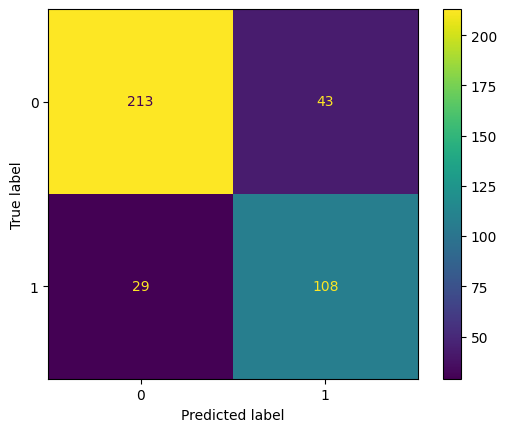

In [56]:
# TODO
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = []
Trues = []
model.eval()
with torch.no_grad():
  for data, target in test_dataloader:
    data, target = data.to(device).reshape(data.shape[0],data.shape[3], data.shape[1], data.shape[2]), target.unsqueeze(1).to(device)
    optimizer.zero_grad()
    output = model(data)
    preds += output.round().tolist()
    Trues += target.tolist()

cm = confusion_matrix(Trues, preds)
ConfusionMatrixDisplay(cm).plot()

#### Your description:
این ماتریس نشان می‌دهد مدل عملکرد نسبتا قابل قبولی دارد ولی عکس‌عای به نسبت زیادی را که سرطان ندارند(۴۳ عدد)را سرطانی تشخیص می‌دهد.

 البته در مقایسه با میزان تصاویری که مدل اشتباهی بدون سرطان تشخیص می‌دهداین نسبت کمتر است. که در مسائل پزشکی این یک نقص جدی است.


# **Exercise 12: Feature Space Visualization (20 points)**:


![feature-space-vis.png](attachment:feature-space-vis.png)

##### You have trained and evaluated your model. Now, for each image in the trainset, calculate it's "feature space" (After Applying Final Pooling).

##### Use **TSNE** to visualize the points in a 2D plane (Set color of each point based on it's class).


In [76]:
model2 = nn.Sequential(*list(model.children())[:-6])

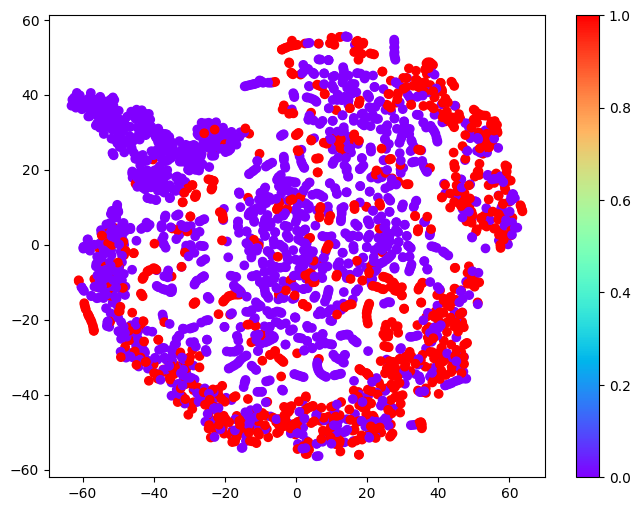

In [98]:
# TODO
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

features = []
labels = []
with torch.no_grad():
  for data, target in train_dataloader:
    data, target = data.to(device).reshape(data.shape[0],data.shape[3], data.shape[1], data.shape[2]), target.unsqueeze(1).to(device)
    output = model2(data)
    features += (output.to('cpu').tolist())
    labels += target.to('cpu').tolist()
features = np.array(features)
labels = np.array(labels)
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(features.squeeze(1).reshape(2828, -1))

plt.figure(figsize=(8, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='rainbow')
plt.colorbar()
plt.show()
